In [9]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import re
import math
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from fuzzywuzzy import process, fuzz
import warnings
import time
import random

warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)

url_header = {
    'User-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.100 Safari/537.36',
    'From': 'djslocum13@gmail.com'
}

In [10]:
def get_draft_pick_values():
    print('-Scraping webpage')
    draft_pick_values_url = 'https://www.theringer.com/nfl/2018/8/20/17758898/fantasy-football-draft-pick-value-chart'
    response = requests.get(draft_pick_values_url, headers=url_header)
    if response.ok:
        soup = bs(response.text, 'html.parser')
        table = soup.find("table",{"class":"p-data-table"})
        header = [th.text for th in table.thead.tr.find_all("th")]
        values = pd.DataFrame([], columns=header)
        for index, tr in enumerate(table.tbody.find_all("tr")):
            vals = []
            for td in tr.find_all('td'):
                vals.append(td.text)
            values.loc[index] = vals
        values['% of no. 1 pick'] = values['% of no. 1 pick'].str.replace('%', '')
        team = np.array([])
        for value in draft_value.values:
            mod8 = value[0] % 8
            mod16 = value[0] % 16
            if mod16 == 0:
                val = 1.0
            elif mod8 == 0:
                val = 8.0
            elif mod16 > 8:
                val = 9 - mod8
            else:
                val = mod8
            team = np.append(team, val)
        values['Team #'] = team
        values = values.astype({'Pick': 'int', 'Value': 'float', '% of no. 1 pick': 'float', 'Team #': 'int'})
        values['Round'] = values.Pick.apply(lambda x: math.ceil(x/8))
        # values.dtypes
    else:
        values = None
    return values



try:
    draft_value = pd.read_csv('draft_value.csv')
    print('-File Found')
except:
    draft_value = get_draft_pick_values()
    draft_value.to_csv('draft_value.csv', index=False)
    print('-Data Collected')
    print('-Data Saved')
    
draft_value.sample(10)

-File Found


,Pick,Value,% of no. 1 pick,Team #,Round
31,32,30.4,33.67,1,4
34,35,28.9,32.00,3,5
112,113,8.6,9.52,1,15
45,46,24.1,26.69,3,6
164,165,2.1,2.33,5,21
39,40,26.6,29.46,8,5
19,20,38.5,42.64,4,3
148,149,3.8,4.21,5,19
141,142,4.7,5.20,3,18
131,132,5.9,6.53,4,17


In [11]:
draft_value[draft_value.Round <= 16].groupby(['Team #']).Value.sum()

Team #
1    393.0
2    381.4
3    374.6
4    370.5
5    367.7
6    365.8
7    364.2
8    363.7
Name: Value, dtype: float64

In [12]:
def get_draft_rankings():
    payload = {
        'csrfmiddlewaretoken': '5L5My2xkICf60HEvTdwU9rmmopM1ltviYeG5SVoOojVVWGQvA3eumMvCel9szylr',
        'username': '###@gmail.com',
        'password': '###',
        'import_id': ''
    }
    fantasy_pros_login = 'https://secure.fantasypros.com/accounts/login/'
    fantasy_pros_rankings = 'https://www.fantasypros.com/nfl/rankings/ppr-cheatsheets.php?filters=35fd0c3d9a'

    session = requests.Session()
    post = session.post(fantasy_pros_login, data=payload, headers=url_header)
    response = session.get(fantasy_pros_rankings, headers=url_header)

    soup = bs(response.text, 'html.parser')
    table = soup.find('table', {'id': 'rank-data'})
    header = [th.text for th in table.thead.find_all('th')]
    header.append('Tier')
    header.append('Team')

    values = pd.DataFrame([], columns=header)
    for index, tr in enumerate(table.tbody.find_all("tr")):
        if 'tier-row' in tr.get('class'):
            tier = tr.get('data-tier')
        elif 'static' in tr.get('class'):
            continue
        elif 'player-row' in tr.get('class'):
            vals = []
            for i, td in enumerate(tr.find_all('td')):
                if i == 2:
                    team = td.small.text
                    vals.append(td.span.text)
                else:
                    vals.append(td.text)
            vals.append(None)
            vals.append(tier)
            vals.append(team)
            values.loc[index] = vals
    values = values.drop(['WSID','Notes\r\n                            '], axis=1)
    values.Pos = values.Pos.apply(lambda x: re.sub('\d', '', x))
    values['vs. ADP'] = values['vs. ADP'].apply(lambda x: re.sub('[+]', '', x))
    values.Team[values.Team == ''] = values[values.Team == '']['Overall (Team)'].apply(lambda x: re.findall(r'(?:[A-Za-z]+\s*[(])([A-Za-z]+)', x)[0])
    values.ADP = values.ADP.str.replace(',', '')
    values.Bye[values.Bye == ''] = 999

    values = values.astype({
        'Rank': 'int',
        'Overall (Team)': 'str',
        'Pos': 'category',
        'Bye': 'int',
        'Best': 'int',
        'Worst': 'int',
        'Avg': 'float',
        'Std Dev': 'float',
        'ADP': 'float',
        'vs. ADP': 'float',
        'Tier': 'int',
        'Team': 'category'
    })

    #values.sample(20)
    #values.dtypes

    return values
    

try:
    draft_rankings = pd.read_csv('draft_rankings.csv')
    print('-File Found')
except:
    draft_rankings = get_draft_rankings()
    draft_rankings.to_csv('draft_rankings.csv', index=False)
    print('-Data Collected')
    print('-Data Saved')
    
draft_rankings.sample(10)

-File Found


,Rank,Overall (Team),Pos,Bye,Best,Worst,Avg,Std Dev,ADP,vs. ADP,Tier,Team
117,118,Donte Moncrief,WR,7,88,149,120.5,14.1,127.0,9.0,9,PIT
337,338,Irv Smith Jr.,TE,12,286,352,325.6,21.4,237.0,-101.0,14,MIN
385,386,Miami (MIA),DST,5,324,355,344.8,12.7,292.0,-94.0,15,MIA
390,391,Kendrick Bourne,WR,4,305,383,333.0,35.4,424.0,33.0,15,SF
31,32,Devonta Freeman,RB,9,16,51,32.5,6.2,34.0,2.0,5,ATL
119,120,Kalen Ballage,RB,5,75,160,122.6,17.7,117.0,-3.0,9,MIA
130,131,Philip Rivers,QB,12,114,161,133.3,14.3,130.0,-1.0,10,LAC
122,123,Jaylen Samuels,RB,7,77,160,126.7,16.8,113.0,-10.0,9,PIT
154,155,D.K. Metcalf,WR,11,111,233,165.4,30.2,111.0,-44.0,10,SEA
69,70,Baker Mayfield,QB,7,54,96,72.2,11.3,58.0,-12.0,7,CLE


In [13]:
draft_keeper_2019 = pd.read_csv('2019_draft_keeper.csv')
draft_keeper_2019

,Order,Team,Keeper
0,1,Hunter,NaN
1,2,Mac,NaN
2,3,Brendan,NaN
3,4,Vinay,NaN
4,5,Danny,NaN
5,6,Zack,NaN
6,7,Nate,NaN
7,8,Bryan,NaN


In [14]:
roster_2018 = pd.read_csv('2018_roster.csv')
roster_2018.sample(10)

,name,position,team,drafted round,keeper round
126,Albert Wilson,WR,FA,NaN,16
216,Deshaun Watson,QB,Danny,5.0,5
235,Lamar Miller,RB,Vinay,7.0,7
155,Nick Foles,QB,FA,NaN,16
27,Davante Adams,WR,Danny,4.0,4
144,Taywan Taylor,WR,FA,NaN,16
37,Sammy Watkins,WR,Brendan,12.0,12
12,Sony Michel,RB,Danny,10.0,10
181,CJ Anderson,RB,Zack,NaN,16
132,CJ Uzomah,TE,FA,NaN,16


In [15]:
draft_value_team_merge = draft_value.merge(draft_keeper_2019[['Order', 'Team']], how='left', left_on='Team #', right_on='Order')
draft_value_team_merge = draft_value_team_merge[draft_value_team_merge.Pick <= 128]
draft_value_team_merge.sample(10)

,Pick,Value,% of no. 1 pick,Team #,Round,Order,Team
95,96,11.4,12.62,1,12,1,Hunter
119,120,7.6,8.42,8,15,8,Bryan
80,81,14.4,15.95,1,11,1,Hunter
107,108,9.4,10.41,5,14,5,Danny
14,15,43.5,48.17,2,2,2,Mac
56,57,20.4,22.59,8,8,8,Bryan
126,127,6.6,7.31,2,16,2,Mac
13,14,44.7,49.50,3,2,3,Brendan
110,111,8.9,9.86,2,14,2,Mac
24,25,34.7,38.43,8,4,8,Bryan


In [16]:
name_validate = np.array([])
draft_rankings['Overall (Team)'] = draft_rankings['Overall (Team)'].str.lower()
for name in roster_2018.name.str.lower():
    estimate = process.extractOne(name, draft_rankings['Overall (Team)'], scorer=fuzz.ratio)
    est1 = estimate[0]
    est_per = estimate[1]
    if (est_per < 100) & (est_per >= 85):
        #print('Name = {}, Estimated = {}, Percent = {}'.format(name, est1, est_per))
        name_validate = np.append(name_validate, est1)
    else:
        name_validate = np.append(name_validate, name)
roster_2018['name_validated'] = name_validate

In [17]:
roster_2018

,name,position,team,drafted round,keeper round,name_validated
0,James Conner,RB,Danny,NaN,16,james conner
1,Nick Chubb,RB,Danny,13.0,13,nick chubb
2,Aaron Jones,RB,FA,NaN,16,aaron jones
3,Patrick Mahomes,QB,Zack,NaN,16,patrick mahomes
4,Kenny Golladay,WR,Zack,NaN,16,kenny golladay
5,Derrius Guice,RB,Hunter,14.0,14,derrius guice
6,Phillip Lindsay,RB,Nate,NaN,16,phillip lindsay
7,Calvin Ridley,WR,Nate,NaN,16,calvin ridley
8,Chris Godwin,WR,Brendan,NaN,16,chris godwin
9,DJ Moore,WR,Mac,NaN,16,d.j. moore


In [18]:
draft_rankings

,Rank,Overall (Team),Pos,Bye,Best,Worst,Avg,Std Dev,ADP,vs. ADP,Tier,Team
0,1,saquon barkley,RB,11,1,3,1.4,0.6,1.0,0.0,1,NYG
1,2,christian mccaffrey,RB,7,1,8,2.4,0.6,2.0,0.0,1,CAR
2,3,alvin kamara,RB,9,1,5,3.0,0.9,3.0,0.0,1,NO
3,4,davante adams,WR,11,4,24,5.7,1.5,8.0,4.0,2,GB
4,5,ezekiel elliott,RB,8,2,13,5.9,2.1,4.0,-1.0,2,DAL
5,6,david johnson,RB,12,1,17,6.2,2.6,5.0,-1.0,2,ARI
6,7,deandre hopkins,WR,10,5,10,6.3,0.7,6.0,-1.0,2,HOU
7,8,michael thomas,WR,9,4,12,9.6,2.1,9.0,1.0,2,NO
8,9,julio jones,WR,9,7,13,9.6,1.6,10.0,1.0,2,ATL
9,10,travis kelce,TE,12,8,16,10.6,2.3,13.0,3.0,3,KC


In [19]:
keeper_merge_table = roster_2018.merge(draft_rankings, how='left', left_on='name_validated', right_on='Overall (Team)')
keeper_merge_table = keeper_merge_table[keeper_merge_table.Rank.notnull()]
keeper_merge_table['Rank'] = keeper_merge_table['Rank'].astype('int')
keeper_values_merge_table = keeper_merge_table.merge(draft_value, how='left', left_on='Rank', right_on='Pick')
keeper_values_merge_table = keeper_values_merge_table.drop(['name','drafted round','Overall (Team)','position','Team #','Best','Worst','Bye'], axis=1)

In [20]:
full_merge = keeper_values_merge_table.merge(draft_value_team_merge[['Team', 'Round', 'Value', 'Pick', '% of no. 1 pick']], how='left', left_on=['team', 'keeper round'], right_on=['Team', 'Round'])
full_merge = full_merge.drop(['Team_y', 'Round_y'], axis=1)
full_merge

,team,keeper round,name_validated,Rank,Pos,Avg,Std Dev,ADP,vs. ADP,Tier,Team_x,Pick_x,Value_x,% of no. 1 pick_x,Round_x,Value_y,Pick_y,% of no. 1 pick_y
0,Danny,16,james conner,14,RB,14.3,2.6,11.0,-3.0,3.0,PIT,14.0,44.7,49.50,2.0,7.0,124.0,7.75
1,Danny,13,nick chubb,15,RB,14.4,3.2,20.0,5.0,3.0,CLE,15.0,43.5,48.17,2.0,10.6,101.0,11.74
2,FA,16,aaron jones,37,RB,35.8,6.5,33.0,-4.0,5.0,GB,37.0,27.9,30.90,5.0,NaN,NaN,NaN
3,Zack,16,patrick mahomes,38,QB,36.8,1.9,18.0,-20.0,5.0,KC,38.0,27.4,30.34,5.0,7.1,123.0,7.86
4,Zack,16,kenny golladay,41,WR,39.4,4.7,42.0,1.0,5.0,DET,41.0,26.1,28.90,6.0,7.1,123.0,7.86
5,Hunter,14,derrius guice,94,RB,93.4,13.9,77.0,-17.0,8.0,WAS,94.0,11.8,13.07,12.0,8.8,112.0,9.75
6,Nate,16,phillip lindsay,58,RB,59.0,7.4,53.0,-5.0,7.0,DEN,58.0,20.1,22.26,8.0,7.3,122.0,8.08
7,Nate,16,calvin ridley,51,WR,53.7,6.6,55.0,4.0,6.0,ATL,51.0,22.4,24.81,7.0,7.3,122.0,8.08
8,Brendan,16,chris godwin,40,WR,38.5,5.1,44.0,4.0,5.0,TB,40.0,26.6,29.46,5.0,6.7,126.0,7.42
9,Mac,16,d.j. moore,50,WR,52.4,4.3,60.0,10.0,6.0,CAR,50.0,22.7,25.14,7.0,6.6,127.0,7.31


In [21]:
full_merge[['name_validated','Pos','Team_x','team', 'keeper round','Pick_y','Value_y','% of no. 1 pick_y','Avg', 'Round_x', 'Rank', 'Value_x', '% of no. 1 pick_x']]

,name_validated,Pos,Team_x,team,keeper round,Pick_y,Value_y,% of no. 1 pick_y,Avg,Round_x,Rank,Value_x,% of no. 1 pick_x
0,james conner,RB,PIT,Danny,16,124.0,7.0,7.75,14.3,2.0,14,44.7,49.50
1,nick chubb,RB,CLE,Danny,13,101.0,10.6,11.74,14.4,2.0,15,43.5,48.17
2,aaron jones,RB,GB,FA,16,NaN,NaN,NaN,35.8,5.0,37,27.9,30.90
3,patrick mahomes,QB,KC,Zack,16,123.0,7.1,7.86,36.8,5.0,38,27.4,30.34
4,kenny golladay,WR,DET,Zack,16,123.0,7.1,7.86,39.4,6.0,41,26.1,28.90
5,derrius guice,RB,WAS,Hunter,14,112.0,8.8,9.75,93.4,12.0,94,11.8,13.07
6,phillip lindsay,RB,DEN,Nate,16,122.0,7.3,8.08,59.0,8.0,58,20.1,22.26
7,calvin ridley,WR,ATL,Nate,16,122.0,7.3,8.08,53.7,7.0,51,22.4,24.81
8,chris godwin,WR,TB,Brendan,16,126.0,6.7,7.42,38.5,5.0,40,26.6,29.46
9,d.j. moore,WR,CAR,Mac,16,127.0,6.6,7.31,52.4,7.0,50,22.7,25.14


In [22]:
full_merge = full_merge.dropna()
full_merge['Value_add'] = full_merge['Value_x'] - full_merge['Value_y']
full_merge['Value_add_norm'] = full_merge['% of no. 1 pick_x'] - full_merge['% of no. 1 pick_y']
full_merge.Round_x = full_merge.Round_x.astype('int')
full_merge_value_table = full_merge[['name_validated','Pos','Team_x','team', 'keeper round', 'Round_x', 'Value_add', 'Value_add_norm']]

In [34]:
full_merge_value_table.sort_values(['Value_add'], ascending=False)[full_merge_value_table.team == 'Bryan']

,name_validated,Pos,Team_x,team,keeper round,Round_x,Value_add,Value_add_norm
72,alvin kamara,RB,NO,Bryan,1,1,16.9,18.72
21,robert woods,WR,LAR,Bryan,9,5,10.6,11.74
93,jared cook,TE,NO,Bryan,16,12,5.3,5.87
45,allen robinson,WR,CHI,Bryan,8,7,1.3,1.44
74,julio jones,WR,ATL,Bryan,2,2,0.0,0.00
224,derrick henry,RB,TEN,Bryan,6,6,-1.2,-1.33
55,stefon diggs,WR,MIN,Bryan,4,4,-2.0,-2.22
57,mitch trubisky,QB,CHI,Bryan,16,18,-2.1,-2.32
56,jarvis landry,WR,CLE,Bryan,6,8,-6.3,-6.97
182,kenyan drake,RB,MIA,Bryan,6,9,-8.5,-9.41


In [24]:
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [25]:
full_merge_viz = full_merge_value_table[full_merge_value_table.Value_add > 0].sort_values(['team','Value_add'], ascending=False)

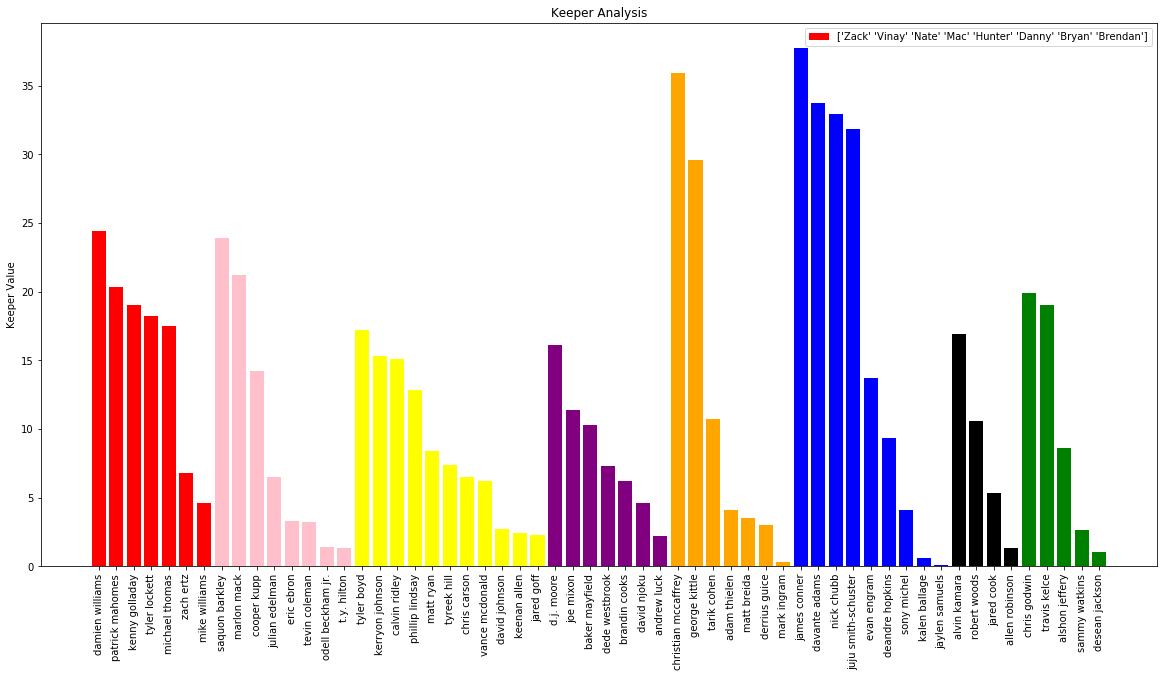

In [26]:
y_val = full_merge_viz['Value_add']
x_val = np.arange(len(y_val))
x_names = full_merge_viz['name_validated']
colors = {
    'Danny':'blue',
    'Zack': 'red',
    'Hunter': 'orange',
    'Nate': 'yellow',
    'Brendan': 'green',
    'Mac': 'purple',
    'Vinay': 'pink',
    'Bryan': 'black'
}
color = [colors[val] for val in full_merge_viz.team]

plt.figure(figsize=(20,10))
plt.bar(x_val, y_val, align='center', color=color, label=full_merge_viz.team.unique())
plt.xticks(x_val, x_names)
plt.xticks(rotation=90)
plt.ylabel('Keeper Value')
plt.title('Keeper Analysis')
plt.legend()
plt.show()

In [27]:
best_keeper_value = full_merge_value_table.groupby(['team'])['Value_add'].max().reset_index()
best_keeper_value

,team,Value_add
0,Brendan,19.9
1,Bryan,16.9
2,Danny,37.7
3,Hunter,35.9
4,Mac,16.1
5,Nate,17.2
6,Vinay,23.9
7,Zack,24.4


In [28]:
my_keeper_trade_values = pd.DataFrame([])
my_keepers = keeper_values_merge_table[keeper_values_merge_table.team == 'Danny']
for team in draft_keeper_2019.Team:
    if team != "Danny":
        my_keepers.team = team
        full_merge = my_keepers.merge(draft_value_team_merge[['Team', 'Round', 'Value', 'Pick', '% of no. 1 pick']], how='left', left_on=['team', 'keeper round'], right_on=['Team', 'Round'])
        full_merge = full_merge.drop(['Team_y', 'Round_y'], axis=1)
        full_merge = full_merge.dropna()
        full_merge['Value_add'] = full_merge['Value_x'] - full_merge['Value_y']
        full_merge['Value_add_norm'] = full_merge['% of no. 1 pick_x'] - full_merge['% of no. 1 pick_y']
        full_merge.Round_x = full_merge.Round_x.astype('int')
        full_merge = full_merge[['name_validated','Pos','Team_x','team', 'keeper round', 'Round_x', 'Value_add', 'Value_add_norm']]
        full_merge['trade_value'] = full_merge.Value_add - float(best_keeper_value.Value_add[best_keeper_value.team == team])
        my_keeper_trade_values = my_keeper_trade_values.append(full_merge, ignore_index=True)
my_keeper_trade_values = my_keeper_trade_values[['name_validated','team','trade_value']].sort_values(['trade_value'], ascending=False)[my_keeper_trade_values.trade_value > 0]

In [425]:
my_keeper_trade_values['trade_round'] = my_keeper_trade_values.trade_value.apply(lambda x: int(draft_value.Round[draft_value.Value == min(draft_value.Value, key=lambda y:abs(y-x))]))

In [426]:
my_keeper_trade_values

,name_validated,team,trade_value,trade_round
10,james conner,Mac,21.9,7
60,james conner,Bryan,21.7,7
50,james conner,Nate,21.1,7
20,james conner,Brendan,19.9,8
61,nick chubb,Bryan,16.6,9
51,nick chubb,Nate,15.7,10
62,juju smith-schuster,Bryan,15.6,10
30,james conner,Vinay,15.2,10
11,nick chubb,Mac,14.9,10
52,juju smith-schuster,Nate,14.7,10


In [411]:
my_keeper_trade_values

,name_validated,team,trade_value
10,james conner,Mac,21.9
60,james conner,Bryan,21.7
50,james conner,Nate,21.1
20,james conner,Brendan,19.9
61,nick chubb,Bryan,16.6
51,nick chubb,Nate,15.7
62,juju smith-schuster,Bryan,15.6
30,james conner,Vinay,15.2
11,nick chubb,Mac,14.9
52,juju smith-schuster,Nate,14.7


In [93]:
espn_rankings = 'https://g.espncdn.com/s/ffldraftkit/19/NFLDK2019_CS_PPR300.pdf'
response = requests.get(espn_url)
soup = bs(response.text, 'html.parser')

In [ ]:
positions = ['qb','rb','wr','te','k','dst']
fantasy_pros_projections = 'https://www.fantasypros.com/nfl/projections/{}.php?max-yes=true&min-yes=true&scoring=PPR&week=draft'
stats_2018 = 'https://www.fantasypros.com/nfl/stats/{}.php?year=2018&scoring=PPR'

In [2]:
fantasypros_username = input("Input FantasyPros Username: ")
fantasypros_password = input("Input FantasyPros Password: ")
payload = {
    'csrfmiddlewaretoken': '5L5My2xkICf60HEvTdwU9rmmopM1ltviYeG5SVoOojVVWGQvA3eumMvCel9szylr',
    'username': fantasypros_username,
    'password': fantasypros_password,
    'import_id': ''
}
session = requests.Session()
print('-Scraping FantasyPros')
fantasy_pros_login = 'https://secure.fantasypros.com/accounts/login/'
post = session.post(fantasy_pros_login, data=payload, headers=url_header)


data = pd.DataFrame([])

Input FantasyPros Username: djslocum13@gmail.com
Input FantasyPros Password: aspen1983
-Scraping FantasyPros


In [3]:
pos = 'qb'
fantasy_pros_projections_url = 'https://www.fantasypros.com/nfl/projections/{}.php?max-yes=true&min-yes=true&scoring=PPR&week=draft'
response = session.get(fantasy_pros_projections_url.format(pos), headers=url_header)
values = None
if response.ok:
    soup = bs(response.text, 'html.parser')
else:
    print("### Error connecting to FantasyPros for the {} position ###".format(pos))

In [15]:
table = soup.find('table', {'class': 'table'})


tr = table.thead.find_all('tr')
if len(tr) == 2:
    thead_top = tr[0].find_all('td')
    thead_top_header = []
    for td in thead_top:
        col_num = td.get("colspan")
        if col_num == None:
            col_num = 1
        thead_top_header += int(col_num) * [td.text]
    header = [thead_top_header[index] + ' ' + th.text for index, th in enumerate(tr[1].find_all('th'))]
elif len(tr) == 1:
    header = [th.text for th in table.thead.find_all('th')]
else: 
    print('### No header found ###')
values = pd.DataFrame([], columns=header)
        
        
for index, tr in enumerate(table.tbody.find_all("tr")):
    vals = []
    for i, td in enumerate(tr.find_all('td')):
        if i == 0:
            name = td.find('a', {'class': 'player-name'}).text
            vals.append(name)
        else:
            vals.append(td.text)
    values.loc[index] = vals
    
data = data.append(values)

In [18]:
td

<td class="center" data-sort-value="0">0.0<div class="max-cell">0.0</div><div class="min-cell">0.0</div></td>